In [1]:
using Plots

## Baseline Parameterization

In [2]:
k = 6  # price_intervals
α = 0.3  # step_size
δ = 0.95  # discount_factor

# convergence if Q doesn't change for 100,000 consecutive periods (Calvano 2020, missing from Klein 2021)
conv_len = 100_000  

P = 0:1/k:1  # prices/action space (state space is competitor prices)

params = (k, α, δ)

(6, 0.3, 0.95)

## Learning

### Define functions

In [3]:
mutable struct Firm
    Q::AbstractMatrix  # Q matrix ∈ M(actions, states)
    prices::Array  # price history (save all for later calculations/plotting)
end
p2in(p) = Int(p * k + 1) # convert price p to index in Q matrix

p2in (generic function with 1 method)

In [4]:
# linear demand (collusive price = 0.5, per-firm profit = 0.125)
function D_i(p_i, p_j)
    if p_i < p_j
        1 - p_i
    elseif p_i == p_j
        0.5 * (1 - p_i)
    else
        0
    end
end


# profit
π_i(p_i, p_j) = p_i * D_i(p_i, p_j)

π_i (generic function with 1 method)

In [5]:
# argmax but returns random if multiple found
rand_argmax(arr::Array) = rand(findall(x -> x == maximum(arr), arr))

rand_argmax (generic function with 1 method)

In [6]:
# argmax but returns maximum if multiple found
max_argmax(arr::Array) = maximum(findall(x -> x == maximum(arr), arr))

max_argmax (generic function with 1 method)

In [7]:
function opt_strategy_rand(Q::Matrix, p::Number)
    """Return optimal strategy with ties chosen randomly"""
    (rand_argmax(Q[:, p2in(p)]) - 1) / k
end

opt_strategy_rand (generic function with 1 method)

In [8]:
function opt_strategy_max(Q::Matrix, p::Number)
    """Return optimal strategy with ties given to the max price"""
    (rand_argmax(Q[:, p2in(p)]) - 1) / k
end

opt_strategy_max (generic function with 1 method)

In [9]:
# update firm's Q matrix at time t
function update_Q!(Q_i::Matrix, p_i::Array, p_j::Array, t::Int)
    
    prev_est = Q_i[p2in(p_i[t]), p2in(p_j[t])]
    new_est =  π_i(p_i[t], p_j[t]) + δ*π_i(p_i[t], p_j[t+1]) + δ^2*maximum(Q_i[:, p2in(p_j[t+1])])
    Q_i[p2in(p_i[t]), p2in(p_j[t])] = (1 - α) * prev_est + α * new_est

    return Q_i
end

update_Q! (generic function with 1 method)

In [37]:
function duopoly(T::Int)
    
    # initialize firms w/ t = {1, 3}
    Q1 = zeros(length(P), length(P))
    Q2 = zeros(length(P), length(P))
            
    prices1 = Array{Float64}(undef,T)
    prices2 = Array{Float64}(undef,T)
            
    prices1[1] = prices1[2] = rand(P)  # t=1
    prices2[1] = prices2[2] = rand(P)  # t=2
    prices1[3], prices2[3] = rand(P), prices2[2]  # t=3
    
    firms = (Firm(Q1, prices1), Firm(Q2, prices2))
    
    converged = false
    prev_Q = [copy(Q1), copy(Q2)]
    unchanged = 0
    
    # update Q matricies
    i, j = 2, 1  # i = firm2 b/c t=4
    for t in 4:T
        
        # update Q at t-2
        update_Q!(firms[i].Q, firms[i].prices, firms[j].prices, t-2)
        
        # update unchanged and check for convergence
        firms[i].Q == prev_Q[i] ? (unchanged += 1) : (unchanged = 0)
        unchanged == conv_len && (converged = true)
        prev_Q[i] = copy(firms[i].Q)
        
        # set new prices
        ϵ = (0.000001)^(t/T)  # ϵ = (1 - θ)^t where decay parameter θ is set s.t. ϵ_T = .0001%
        firms[i].prices[t] = rand() < ϵ ? rand(P) : opt_strategy_rand(firms[i].Q, firms[j].prices[t-1])
        firms[j].prices[t] = firms[j].prices[t-1] 
        
        # swap i and j b/c sequential
        i, j = j, i  
    end
    
    return firms, converged
end

duopoly (generic function with 1 method)

In [11]:
function getprofits(prices1, prices2)
    profits1 = [π_i(prices1[t], prices2[t]) for t in 1:length(prices1)]
    profits2 = [π_i(prices2[t], prices1[t]) for t in 1:length(prices1)] 
    profits1, profits2
end

getprofits (generic function with 1 method)

In [12]:
function makeplots(prices1, prices2, profits1, profits2, step::Int; titled = "")
    x = 1:step:length(prices1)
    p1 = plot(x, [prices1[x] prices2[x]], ylim =(0, 1), title = "Price (every $(step)th)")
    p2 = plot(x, [profits1[x] profits2[x]], title = "Profit (every $(step)th)")
    plot(p1, p2, label=["Firm 1" "Firm 2"], layout=(2,1), plot_title=titled, titlelocation=:left)
end

makeplots (generic function with 1 method)

### Run experiment

In [38]:
T = 500_000

firms, converged = duopoly(T)
firm1, firm2 = firms

# calculate profit history
profits1, profits2 = getprofits(firm1.prices, firm2.prices)

@show converged
firm1.prices[end], profits1[end], firm2.prices[end], profits2[end]

converged = false


(0.3333333333333333, 0.11111111111111112, 0.3333333333333333, 0.11111111111111112)

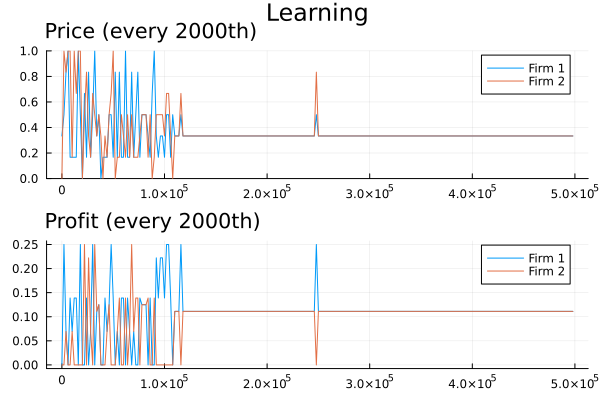

In [39]:
makeplots(firm1.prices, firm2.prices, profits1, profits2, 2_000, titled = "Learning")

## Performance metrics

### Define metrics

#### PROBLEM - convergence method doesn't work properly (optimal Q-matrix varies)

In [40]:
function optimal_Q(firm_i::Firm, firm_j::Firm; max_periods=10_000_000)
    """Calculate optimal Q-function given current competitor strategy"""
    
    main = Firm(copy(firm_i.Q), firm_i.prices[end-1:end])
    comp = Firm(firm_j.Q, firm_j.prices[end-1:end])
    
    firms = (main, comp)
    
    # loop over all action-state pairs in Q until convergence
    # convergence if Q doesn't change for 100,000 consecutive periods (Calvano 2020, missing from Klein 2021)
    i, j = 1, 2
    periods = 0
    prev_Q = copy(firms[i].Q)
    unchanged = 0  # periods Q has remained unchanged
    while true
        
        # stop if hasnt converged
        periods == max_periods && break
        
        # update Q if firm is main (to get optimal)
        if i == 1
            
            update_Q!(firms[i].Q, firms[i].prices, firms[j].prices, 1)
            
            # update unchanged and check for convergence
            firms[i].Q == prev_Q ? (unchanged += 1) : (unchanged = 0)
            unchanged == conv_len && break
            prev_Q = copy(firms[i].Q)
            
            # set epsilon to .1 b/c cant use decay since dont know when will converge 
            # perhaps theres a better value / way to decay?
            ϵ = .1
            firms[i].prices[2] = rand() < ϵ ? rand(P) : opt_strategy_rand(firms[i].Q, firms[j].prices[2])
        else
            firms[i].prices[2] = opt_strategy_max(firms[i].Q, firms[j].prices[2])
            
        end
        firms[j].prices[1] = firms[j].prices[2]  # future price becomes current price 
        
        i, j = j, i  
        periods += 1
    end
    firms[1].Q
end

optimal_Q (generic function with 1 method)

In [41]:
# profitability: avg profit of final 1000 periods
Π_i(profits::Array{Float64}) = sum(profits[end-999:end]) / 1000

Π_i(profits1), Π_i(profits2)

(0.1111111111111108, 0.1111111111111108)

In [42]:
# optimality: ratio of estimated and best-response discounted future profits
function Γ_i(firm_i::Firm, firm_j::Firm)
    ind_i, ind_j = (p2in(firm_i.prices[end]), p2in(firm_j.prices[end]))
    firm_i.Q[ind_i, ind_j] / maximum(optimal_Q(firm_i, firm_j)[:, ind_j])
end

Γ_i(firm1, firm2)

1.0

In [43]:
# check if outcome is a Nash equilibrium
isNash(firm_i, firm_j; tol = 0.000001) = isapprox(Γ_i(firm_i, firm_j), 1, atol = tol) && 
    isapprox(Γ_i(firm_j, firm_i), 1, atol = tol)

isNash(firm1, firm2)

true

In [44]:
best_response = optimal_Q(firm1, firm2) 

7×7 Matrix{Float64}:
 2.10583  2.0375   2.10583  1.79475  2.10583  2.10583  1.71821
 1.90528  1.74951  2.04417  1.88039  2.04417  2.04417  1.63947
 2.11111  1.71542  2.22222  2.4072   2.33333  2.33333  1.65973
 2.00556  1.72774  2.00556  1.82784  2.25556  2.25556  2.30484
 2.00556  1.68025  2.00556  1.59752  2.11667  2.22778  1.77421
 2.10583  1.80338  2.10583  1.6962   2.10583  2.17528  1.74609
 2.00556  1.51598  2.00556  1.57292  2.00556  2.00556  1.70588

### Let firms compete (for testing)

In [45]:
function compete(firm_i::Firm, firm_j::Firm, periods::Int)
    firms = (firm_i, firm_j)
    tprices = (Array{Float64}(undef,periods), Array{Float64}(undef,periods))
    tprices[1][1] = 1
    
    i, j = 2, 1
    for t in 2:periods
        tprices[i][t] = opt_strategy_max(firms[i].Q, tprices[j][t-1])
        tprices[j][t] = tprices[j][t-1] 
        i, j = j, i
    end
    tprices
end

compete (generic function with 1 method)

sum(tprofits1) = 2.0


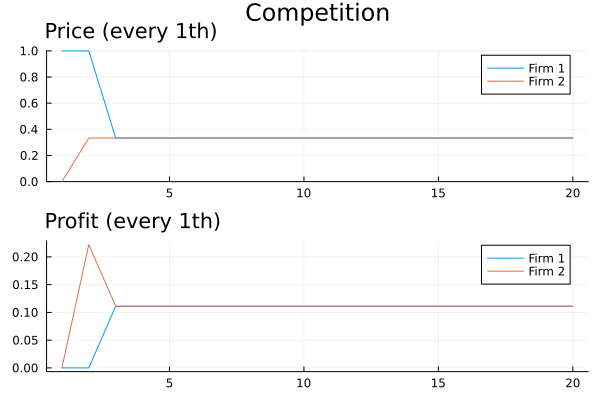

In [53]:
tprices = compete(firm1, firm2, 20)
tprofits1, tprofits2 = getprofits(tprices[1], tprices[2])
@show sum(tprofits1)

makeplots(tprices[1], tprices[2], tprofits1, tprofits2, 1, titled="Competition")

sum(tprofits1) = 2.0


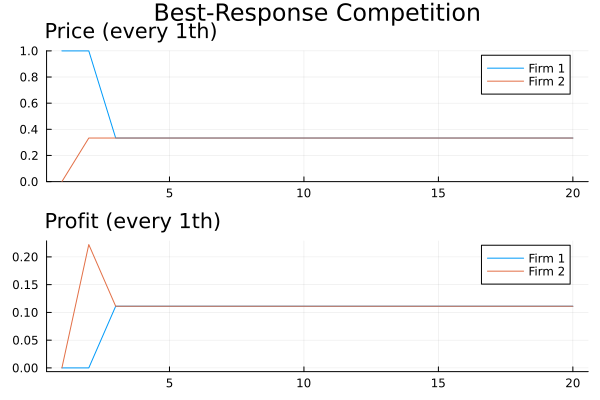

In [54]:
tprices = compete(Firm(best_response, []), firm2, 20)
tprofits1, tprofits2 = getprofits(tprices[1], tprices[2])
@show sum(tprofits1)

makeplots(tprices[1], tprices[2], tprofits1, tprofits2, 1, titled="Best-Response Competition")

### Frequency of convergence prices on multiple runs

#### Figure 2 in Klein 2021 had 667/1000 runs lead to a Nash equilibrium

In [23]:
T = 500_000
runs = 100 # 1000

convg_prices = Array{Tuple{Float64, Float64}}(undef,runs)
nashcount = 0
for i in 1:runs
    firms, converged = duopoly(T)
    convg_prices[i] = (firms[1].prices[end], firms[2].prices[end])
    
    nashcount += isNash(firms[1], firms[2])
end

LoadError: InterruptException:

In [24]:
nashcount  # inaccurate b/c problem w/ optimality function

15

In [25]:
freq = Dict()
for tup in convg_prices
    freq[tup] = get(freq, tup, 0) + 1
end
sorted = sort(freq, byvalue=true, rev=true)

OrderedCollections.OrderedDict{Any, Any} with 14 entries:
  (0.0, 0.0)           => 47
  (0.5, 0.5)           => 10
  (5.0e-324, 5.0e-324) => 10
  (0.333333, 0.333333) => 8
  (5.0e-324, 0.0)      => 7
  (0.0, 5.0e-324)      => 7
  (5.0e-324, 1.0e-323) => 3
  (0.333333, 0.166667) => 2
  (0.666667, 0.5)      => 1
  (0.833333, 0.5)      => 1
  (1.0e-323, 5.0e-324) => 1
  (0.166667, 0.166667) => 1
  (0.5, 0.333333)      => 1
  (0.166667, 1.0)      => 1